In [29]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

stage_name = "stage2"
model_dir = f"results/regime/{stage_name}/models"
data_dir = f"results/regime/{stage_name}/data"
figures_dir = f"results/regime/{stage_name}/figures"
save_figures = False

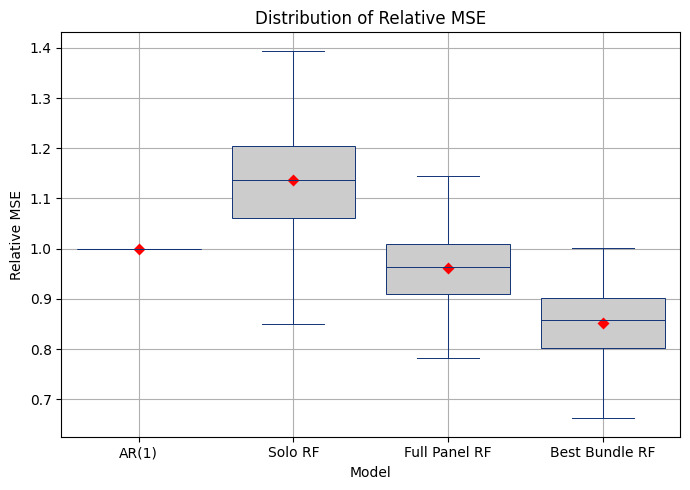

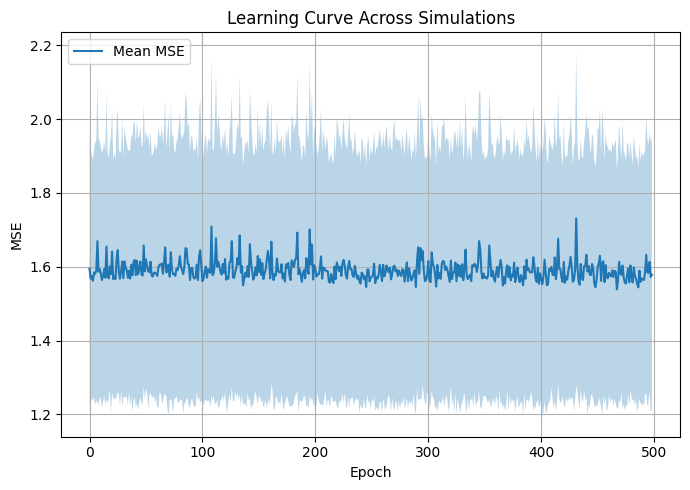

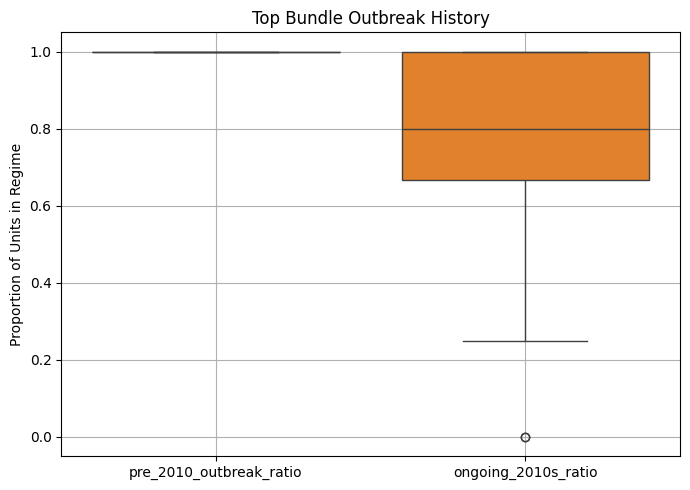

In [30]:
benchmark_records = []
bundle_records = []
learning_curves = []

for file in sorted(os.listdir(model_dir)):
    if not file.endswith(".pkl"):
        continue

    sim_id = int(file.split("_")[-1].split(".")[0])
    model_path = os.path.join(model_dir, file)
    data_path = os.path.join(data_dir, f"df_sim_{sim_id}.parquet")
    if not os.path.exists(model_path) or not os.path.exists(data_path):
        continue

    with open(model_path, "rb") as f:
        results = pickle.load(f)
    df = pd.read_parquet(data_path)
    df["period"] = pd.to_datetime(df["period"])

    # --- Relative MSE
    benchmarks = results["benchmarks"]
    ar1 = benchmarks["ar1_mse"]
    benchmark_records.append({
        "sim_id": sim_id,
        "AR(1)": 1.0,
        "Solo RF": benchmarks["solo_rf_mse"] / ar1,
        "Full Panel RF": benchmarks["full_panel_rf_mse"] / ar1,
        "Best Bundle RF": benchmarks["best_bundle_rf_mse"] / ar1,
    })

    # --- Bundle diagnostics
    bundle_units = results["top_bundles"][0][1]
    total = len(bundle_units)
    pre_2010 = 0
    during_2010s = 0

    for unit in bundle_units:
        d = df[df["unit"] == unit]
        
        if ((d["period"] < pd.Timestamp("2010-03-01")) & (d["delta"] == 1)).any():
            pre_2010 += 1
        
        if ((d["period"] >= pd.Timestamp("2010-03-01")) &
            (d["period"] <= pd.Timestamp("2024-12-01")) &
            (d["delta"] == 1)).any():
            during_2010s += 1

    bundle_records.append({
        "sim_id": sim_id,
        "bundle_size": total,
        "pre_2010_outbreak_ratio": pre_2010 / total if total > 0 else np.nan,
        "ongoing_2010s_ratio": during_2010s / total if total > 0 else np.nan
    })

    learning_curves.append(results["avg_mse_per_epoch"])

# --- Plot 1: Relative Benchmark Comparison
df_bench = pd.DataFrame(benchmark_records).melt(id_vars="sim_id", var_name="model", value_name="relative_mse")
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_bench, x="model", y="relative_mse", color=".8", linecolor="#137", linewidth=.7, showfliers=False)
sns.pointplot(data=df_bench, x="model", y="relative_mse",
              estimator="mean", color="red", markers="D",
              linestyles="none", err_kws={'linewidth': 0}, markersize=4)
plt.title("Distribution of Relative MSE")
plt.ylabel("Relative MSE")
plt.xlabel("Model")
plt.grid(True)
plt.tight_layout()
if save_figures:
    plt.savefig(os.path.join(figures_dir, f"{stage_name}_boxplot.pdf"), format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# --- Plot 2: Learning Curve
df_learn = pd.DataFrame(learning_curves)
plt.figure(figsize=(7, 5))
mean_curve = df_learn.mean()[:-1]
std_curve = df_learn.std()[:-1]
plt.plot(mean_curve.index, mean_curve.values, label="Mean MSE")
plt.fill_between(mean_curve.index, mean_curve - std_curve, mean_curve + std_curve, alpha=0.3)
plt.title("Learning Curve Across Simulations")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
if save_figures:
    plt.savefig(os.path.join(figures_dir, f"{stage_name}_learning_curve.pdf"), format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# --- Plot 3: Bundle History Diagnostics
df_bundle = pd.DataFrame(bundle_records)
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_bundle[["pre_2010_outbreak_ratio", "ongoing_2010s_ratio"]])
plt.title("Top Bundle Outbreak History")
plt.ylabel("Proportion of Units in Regime")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
df_bench.groupby("model")["relative_mse"].describe().T

model,AR(1),Best Bundle RF,Full Panel RF,Solo RF
count,100.0,100.000000,100.000000,100.000000
mean,1.0,0.852728,0.961080,1.136569
std,0.0,0.073087,0.083348,0.155553
min,1.0,0.662012,0.740011,0.747746
25%,1.0,0.802138,0.910059,1.060694
50%,1.0,0.858604,0.964202,1.137559
75%,1.0,0.901927,1.009064,1.205201
max,1.0,1.002273,1.216528,1.878570


In [32]:
df_bundle.describe()

,sim_id,bundle_size,pre_2010_outbreak_ratio,ongoing_2010s_ratio
count,100.000000,100.000000,100.0,100.000000
mean,49.500000,3.460000,1.0,0.798238
std,29.011492,1.209558,0.0,0.239098
min,0.000000,1.000000,1.0,0.000000
25%,24.750000,3.000000,1.0,0.666667
50%,49.500000,3.000000,1.0,0.800000
75%,74.250000,4.000000,1.0,1.000000
max,99.000000,7.000000,1.0,1.000000


In [33]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_extreme_donor_similarity(model_dir, data_dir, stage_name="stage2", 
                                  target_rho=0.8, target_gamma=1.4, sim_range=range(100), 
                                  save_figures=False, figures_dir="figures"):
    """
    Plots the parameter similarity of the most and least included donors across simulations.
    If stage is 'stage1', it also plots the KDE for Unit A’s own parameters.

    Parameters:
    - model_dir: path to folder with model output .pkl files
    - data_dir: path to folder with .parquet simulation datasets
    - stage_name: string identifying the stage ("stage1", "stage2", etc.)
    - target_rho: fixed rho value for target unit A (used as visual reference)
    - target_gamma: fixed gamma value for target unit A (used as visual reference)
    - sim_range: iterable of simulation IDs to include
    - save_figures: whether to save the plot to disk
    - figures_dir: folder to save the figure if save_figures is True
    """
    best_rho, best_gamma = [], []
    worst_rho, worst_gamma = [], []
    rho_A_vals, gamma_A_vals = [], []

    for sim_id in sim_range:
        try:
            with open(os.path.join(model_dir, f"results_sim_{sim_id}.pkl"), "rb") as f:
                results = pickle.load(f)
            df = pd.read_parquet(os.path.join(data_dir, f"df_sim_{sim_id}.parquet"))
        except Exception as e:
            print(f"Skipping sim {sim_id} due to load error: {e}")
            continue

        # Extract donor parameters
        df_params = df.groupby("unit")[["rho_i", "gamma_i"]].first().reset_index()
        unit_params = dict(zip(df_params["unit"], zip(df_params["rho_i"], df_params["gamma_i"])))

        if stage_name == "stage1":
            # Record A's parameters
            if "A" in unit_params:
                rho_A_vals.append(unit_params["A"][0])
                gamma_A_vals.append(unit_params["A"][1])

        inclusion_probs = results.get("inclusion_probs_by_donor", {})
        if not inclusion_probs:
            continue

        # Last inclusion prob per donor
        final_probs = {
            donor: probs[-1] for donor, probs in inclusion_probs.items()
            if donor in unit_params and len(probs) > 0
        }
        if not final_probs:
            continue

        # Identify best/worst donors
        best_donor = max(final_probs, key=final_probs.get)
        worst_donor = min(final_probs, key=final_probs.get)

        best_rho.append(unit_params[best_donor][0])
        best_gamma.append(unit_params[best_donor][1])
        worst_rho.append(unit_params[worst_donor][0])
        worst_gamma.append(unit_params[worst_donor][1])
    
    # Combine into a DataFrame
    if stage_name == "stage1":

        df_param_compare = pd.DataFrame({
            "rho_A": rho_A_vals,
            "gamma_A": gamma_A_vals,
            "rho_best": best_rho,
            "gamma_best": best_gamma
        })
    else:
        df_param_compare = pd.DataFrame()

    # --- Plotting ---
    plt.figure(figsize=(7, 5))

    if stage_name == "stage1":
        sns.kdeplot(x=gamma_A_vals, y=rho_A_vals, cmap="Greens", fill=True,
                    alpha=0.4, label="Unit A (target)", levels=8, thresh=0.05)
        sns.kdeplot(x=best_gamma, y=best_rho, cmap="Reds", fill=True,
                    alpha=0.5, label="Most included donors", levels=8, thresh=0.05)
        
    else:

        sns.kdeplot(x=worst_gamma, y=worst_rho, cmap="Blues", fill=True,
                    alpha=0.4, label="Least included donors", levels=8, thresh=0.05)
        sns.kdeplot(x=best_gamma, y=best_rho, cmap="Reds", fill=True,
                    alpha=0.5, label="Most included donors", levels=8, thresh=0.05)
        plt.scatter([target_gamma], [target_rho], color="black", marker="*", s=200, label="Target A (ρ=0.8, γ=1.4)")

    plt.xlabel("γ (Donor Risk Sensitivity)")
    plt.ylabel("ρ (Donor Persistence)")
    plt.title("Donor Parameter Similarity to Target Unit A")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save_figures:
        os.makedirs(figures_dir, exist_ok=True)
        plt.savefig(os.path.join(figures_dir, f"{stage_name}_contour_plot.pdf"), format="pdf", bbox_inches="tight", dpi=300)

    plt.show()

    return df_param_compare

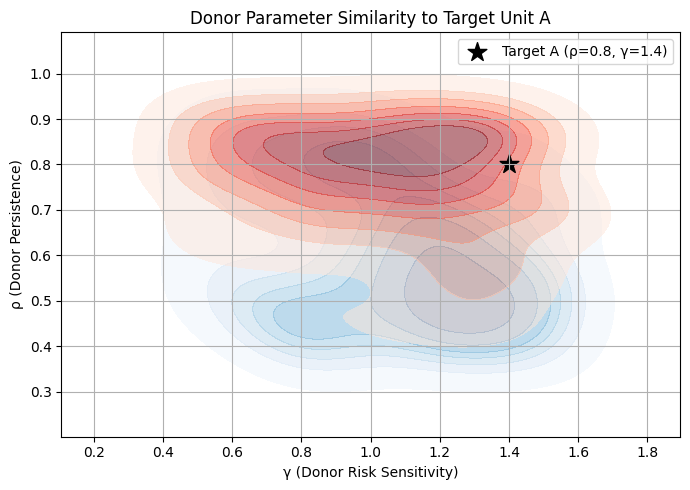

In [34]:
df_param_compare = plot_extreme_donor_similarity(model_dir, data_dir, stage_name=stage_name, figures_dir=figures_dir, save_figures=save_figures)

In [35]:
# Scatterplot: ρ comparison
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_param_compare, x="rho_A", y="rho_best")
plt.xlabel("ρ (A)")
plt.ylabel("ρ (Best Donor)")
plt.title("Comparison of ρ Between A and Best Donor")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatterplot: γ comparison
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_param_compare, x="gamma_A", y="gamma_best")
plt.xlabel("γ (A)")
plt.ylabel("γ (Best Donor)")
plt.title("Comparison of γ Between A and Best Donor")
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `rho_A` for `x`. An entry with this name does not appear in `data`.

<Figure size 600x400 with 0 Axes>